In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from ydata_profiling import ProfileReport
import src.dataHandling.cleaningUtils as clean
import os
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [37]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
     'font.family': 'serif',
     'text.usetex': True,
     'pgf.rcfonts': False,
})

In [3]:
def drop_irrelevant(df: pd.DataFrame) -> pd.DataFrame:
    """
    drops columns which are irrelevant for the model (mostly ids)
    :param df: pd.DataFrame
    :return: None
    """
    irrelevant_cols = []
    general_irrelevant = ['gameDuration', 'gameCreation', 'gameVersion', 'mapId', 'queueId', 'patch', 'seasonId',
                          'platformId']
    irrelevant_cols.extend(general_irrelevant)
    participant_irrelevant = ['win', 'lp', 'inactive', 'teamId']
    for i in range(1, 11):
        for col in participant_irrelevant:
            irrelevant_cols.append(f'participant{i}_{col}')
    df_new = df.drop(columns=irrelevant_cols)
    return df_new

In [89]:
dir = 'data/static_16_12_23/raw/static_full.pkl'
try:
    with open(dir, "rb") as f:
        df = pickle.load(f)
except FileNotFoundError:
    os.chdir('../')
    with open(dir, "rb") as f:
        df = pickle.load(f)
df = clean.drop_wrong_data(df)
df.reset_index(drop=True, inplace=True)
df = clean.fix_rank(df)
df = clean.calc_winrate(df)
df = clean.fix_teamId(df)
df = clean.convert_booleans(df)
df = clean.convert_lastPlayTime(df)
df = clean.convert_championTier(df)
df = clean.get_winning_team(df)  # this has to be the last step where a column is inserted
df = clean.drop_wrong_teamIds(df)
df = drop_irrelevant(df)
df = clean.drop_missing(df)
assert df.columns[-1] == 'label'
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
                                                    df.iloc[:, -1],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  shuffle=True)
df = df.copy()

found 30573 rows


KeyError: 'mapId'

In [3]:
df = pd.read_pickle('../data/static_16_12_23/processed/merged_only/train_static.pkl')
df_val = pd.read_pickle('../data/static_16_12_23/processed/merged_only/val_static.pkl')

In [4]:
len(df)

30573

In [5]:
df.head()

,level_team1,level_team2,champion_infoAttack_team1,champion_infoAttack_team2,champion_infoDefense_team1,champion_infoDefense_team2,champion_infoMagic_team1,champion_infoMagic_team2,champion_infoDifficulty_team1,champion_infoDifficulty_team2,...,maxKills_team2,cs_team1,cs_team2,damage_team1,damage_team2,gold_team1,gold_team2,winrate_team1,winrate_team2,label
0,-1.791446,-1.365861,0.759027,-2.774493,-0.938588,-0.701285,0.438913,0.006109,0.876466,-1.291809,...,0.583546,-0.375539,0.146410,-0.048726,0.106925,-0.637481,-0.584104,0.513291,0.227987,1.0
1,1.051238,-0.356770,-2.365212,1.204871,0.296528,2.010222,0.438913,-1.494962,0.441498,-0.640088,...,-0.256678,-1.335760,-1.109598,-0.427521,-1.135473,-0.953593,-0.900453,-0.709826,1.457234,1.0
2,-0.160600,-1.399769,0.312707,1.647023,-0.691564,0.284718,0.869959,-1.280523,0.006530,-0.205608,...,-0.396715,0.143632,-0.886810,-0.895455,-0.939292,-0.503927,-1.014958,-0.845368,0.136047,1.0
3,-1.228660,-0.305230,-0.133613,-0.784811,0.543551,-0.947785,1.301005,1.078303,0.876466,1.097833,...,-0.536753,0.218496,-0.617204,0.185608,-1.083911,-0.062386,-1.290176,1.058477,-1.077558,1.0
4,0.200898,-0.718903,-1.026253,-0.563735,1.037597,-0.947785,0.223390,0.434987,1.093949,-1.291809,...,0.583546,0.312891,0.503193,1.067944,0.660930,0.802670,0.017110,-0.065102,0.217169,0.0


In [6]:
corr_pearson = df.corr()
corr_pearson_target = abs(corr_pearson["label"])
relevant_features = corr_pearson_target[corr_pearson_target > 0.05]
corr_pearson_target.sort_values(ascending=False)


label                            1.000000
kda_team2                        0.289496
kda_team1                        0.284145
assists_team1                    0.194174
deaths_team2                     0.189575
                                   ...   
champion_infoDefense_team1       0.004175
champion_infoDifficulty_team1    0.002722
level_team1                      0.002237
inactive_team1                        NaN
inactive_team2                        NaN
Name: label, Length: 61, dtype: float64

In [7]:
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
print(cols_to_drop)
df.drop(cols_to_drop, axis=1, inplace=True)
df_val.drop(cols_to_drop, axis=1, inplace=True)

Index(['inactive_team1', 'inactive_team2'], dtype='object')


In [8]:
zero_columns = df.columns[df.eq(0).all(axis=0)]
zero_columns

Index([], dtype='object')

In [9]:
from scipy.stats import pearsonr

results = []
for column in df.columns:
    if column != 'label':
        corr, pval = pearsonr(df[column], df['label'])
        results.append({'Feature': column, 'Correlation': corr, 'P-Value': pval})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Correlation', ascending=False, key=abs)

In [10]:
results_df

,Feature,Correlation,P-Value
41,kda_team2,0.289496,0.000000e+00
40,kda_team1,-0.284145,0.000000e+00
46,assists_team1,-0.194174,1.733211e-257
45,deaths_team2,-0.189575,2.583306e-245
47,assists_team2,0.185224,4.388434e-234
44,deaths_team1,0.176814,3.633566e-213
43,kills_team2,0.135435,4.260838e-125
42,kills_team1,-0.132300,2.060684e-119
55,gold_team2,0.126342,5.456746e-109
54,gold_team1,-0.122248,4.111656e-102


In [11]:
results_df[results_df['P-Value'] > 0.05].sort_values(by='Correlation', ascending=False, key=abs)

,Feature,Correlation,P-Value
2,champion_infoAttack_team1,0.011041,0.053542
31,lastPlayTime_team2,0.009313,0.103460
7,champion_infoMagic_team2,0.008120,0.155699
1,level_team2,-0.007926,0.165820
6,champion_infoMagic_team1,0.005124,0.370349
19,champion_matches_team2,-0.004523,0.429047
25,veteran_team2,0.004366,0.445223
4,champion_infoDefense_team1,-0.004175,0.465441
8,champion_infoDifficulty_team1,-0.002722,0.634108
0,level_team1,0.002237,0.695643


In [12]:
results_df['Correlation'] = results_df['Correlation'].abs().sort_values(ascending=False)

In [36]:
results_df['category'] = results_df['Feature'].str.extract(r'(\w+)_team(\d)', expand=False)[0]
pd.set_option('display.max_rows', results_df.shape[0]+1)
results_df.sort_values(by='Correlation', ascending=False, key=abs)

,Feature,Correlation,P-Value,category
41,kda_team2,0.289496,0.000000e+00,kda
40,kda_team1,0.284145,0.000000e+00,kda
46,assists_team1,0.194174,1.733211e-257,assists
45,deaths_team2,0.189575,2.583306e-245,deaths
47,assists_team2,0.185224,4.388434e-234,assists
44,deaths_team1,0.176814,3.633566e-213,deaths
43,kills_team2,0.135435,4.260838e-125,kills
42,kills_team1,0.132300,2.060684e-119,kills
55,gold_team2,0.126342,5.456746e-109,gold
54,gold_team1,0.122248,4.111656e-102,gold


In [14]:
average_per_category = results_df.groupby('category')['Correlation'].mean().sort_values(ascending=False)
df_avg = average_per_category.reset_index()
df_avg.columns = ['Category', 'Correlation']
df_avg['Category'] = df_avg['Category'].str.replace('_', '')
pd.set_option('display.max_rows', df_avg.shape[0]+1)

df_avg

,Category,Correlation
0,kda,0.286821
1,assists,0.189699
2,deaths,0.183195
3,kills,0.133868
4,gold,0.124295
5,damage,0.084492
6,championLevel,0.069397
7,hotStreak,0.065783
8,winrate,0.058317
9,cs,0.057844


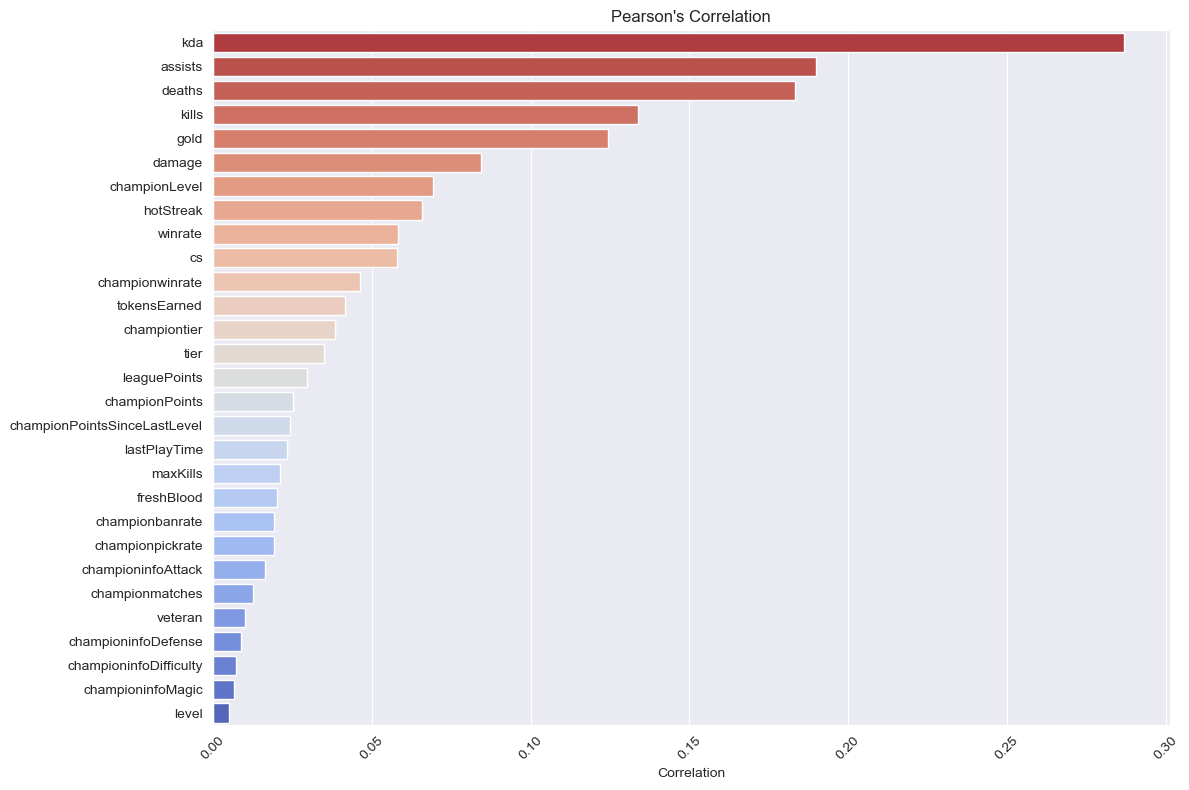

In [15]:
blue_palette = sns.color_palette("blend:cornflowerblue,navy", 5)  # Adjust the number if needed
red_palette = sns.color_palette("blend:lightcoral,firebrick", 5)  # Adjust the number if needed

# Combine the palettes
combined_palette = sns.color_palette("coolwarm_r", len(df_avg))

plt.figure(figsize=(12, 8))
ax = sns.barplot(y='Category', x='Correlation', data=df_avg, palette=combined_palette)
ax.set_ylabel('')
plt.xticks(rotation=45)
plt.title("Pearson's Correlation")
plt.tight_layout()
#plt.savefig('thesis/images/pearson_correlation.pgf', bbox_inches='tight')
plt.show()

In [16]:
bst = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, objective='binary:logistic')

In [17]:
bst.fit(df.iloc[:, :-1], df.iloc[:, -1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
bst.score(df_val.iloc[:,:-1], df_val.iloc[:, -1])

0.69225

In [19]:
feature_important = bst.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data

,score
kda_team2,92.0
kda_team1,85.0
gold_team2,48.0
gold_team1,42.0
leaguePoints_team1,42.0
...,...
level_team2,1.0
championPoints_team1,1.0
championPoints_team2,1.0
tokensEarned_team2,1.0


In [23]:
data_reset = data.reset_index()
data_reset['category'] = data_reset['index'].str.extract(r'(\w+)_team(\d)', expand=False)[0]
average_per_category = data_reset.groupby('category').mean()
average_per_category = average_per_category.sort_values(by='score', ascending=False)
pd.set_option('display.max_rows', average_per_category.shape[0]+1)

average_per_category

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,score
category,
kda,88.5
gold,45.0
leaguePoints,37.5
assists,27.0
deaths,21.5
maxKills,19.0
lastPlayTime,16.0
winrate,12.5
kills,11.5


In [24]:
average_per_category['normalized_score'] = (average_per_category['score'] - average_per_category['score'].min()) / (average_per_category['score'].max() - average_per_category['score'].min())
average_per_category

,score,normalized_score
category,,
kda,88.5,1.000000
gold,45.0,0.502857
leaguePoints,37.5,0.417143
assists,27.0,0.297143
deaths,21.5,0.234286
maxKills,19.0,0.205714
lastPlayTime,16.0,0.171429
winrate,12.5,0.131429
kills,11.5,0.120000


In [25]:
average_per_category = average_per_category.reset_index()
average_per_category.columns = ['Category','score', 'normalized_score']
average_per_category = average_per_category[average_per_category['normalized_score'] > 0]
average_per_category

,Category,score,normalized_score
0,kda,88.5,1.000000
1,gold,45.0,0.502857
2,leaguePoints,37.5,0.417143
3,assists,27.0,0.297143
4,deaths,21.5,0.234286
5,maxKills,19.0,0.205714
6,lastPlayTime,16.0,0.171429
7,winrate,12.5,0.131429
8,kills,11.5,0.120000
9,championLevel,8.5,0.085714


In [26]:
df_avg['normalized_correlation'] = (df_avg['Correlation'] - df_avg['Correlation'].min()) / (df_avg['Correlation'].max() - df_avg['Correlation'].min())
df_avg

,Category,Correlation,normalized_correlation
0,kda,0.286821,1.000000
1,assists,0.189699,0.655278
2,deaths,0.183195,0.632192
3,kills,0.133868,0.457112
4,gold,0.124295,0.423135
...,...,...,...
24,veteran,0.010014,0.017509
25,championinfoDefense,0.008884,0.013498
26,championinfoDifficulty,0.007457,0.008431
27,championinfoMagic,0.006622,0.005466


In [27]:
df_both = pd.merge(average_per_category, df_avg, how='inner', on='Category')
pd.set_option('display.max_rows', df_both.shape[0]+1)

df_both.columns = ['Category', 'score', 'GBT', 'Correlation', 'PCC']
df_both

,Category,score,GBT,Correlation,PCC
0,kda,88.5,1.000000,0.286821,1.000000
1,gold,45.0,0.502857,0.124295,0.423135
2,leaguePoints,37.5,0.417143,0.029559,0.086881
3,assists,27.0,0.297143,0.189699,0.655278
4,deaths,21.5,0.234286,0.183195,0.632192
5,maxKills,19.0,0.205714,0.021015,0.056553
6,lastPlayTime,16.0,0.171429,0.023367,0.064903
7,winrate,12.5,0.131429,0.058317,0.188953
8,kills,11.5,0.120000,0.133868,0.457112
9,championLevel,8.5,0.085714,0.069397,0.228281


In [45]:
df_long = pd.melt(df_both.iloc[:13], id_vars=['Category'], value_vars=['GBT', 'PCC'], var_name='Type', value_name='Value')
df_long

,Category,Type,Value
0,kda,GBT,1.000000
1,gold,GBT,0.502857
2,leaguePoints,GBT,0.417143
3,assists,GBT,0.297143
4,deaths,GBT,0.234286
5,maxKills,GBT,0.205714
6,lastPlayTime,GBT,0.171429
7,winrate,GBT,0.131429
8,kills,GBT,0.120000
9,championLevel,GBT,0.085714


In [46]:
for col in ['Category', 'Type']:
    df_long[col] = df_long[col].str.replace('_', '')


In [49]:
categories_spelling = ['KDA', 'Gold', 'League Points', 'Assists', 'Deaths', 'Max Kills', 'Last Play Time', 'Win Rate', 'Kills', 'Champion Level', 'Hot Streak', 'Damage', 'Creep Score']
df_long['Category'] = categories_spelling * 2

In [50]:
df_long

,Category,Type,Value
0,KDA,GBT,1.000000
1,Gold,GBT,0.502857
2,League Points,GBT,0.417143
3,Assists,GBT,0.297143
4,Deaths,GBT,0.234286
5,Max Kills,GBT,0.205714
6,Last Play Time,GBT,0.171429
7,Win Rate,GBT,0.131429
8,Kills,GBT,0.120000
9,Champion Level,GBT,0.085714


In [51]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(y='Category', x='Value', hue='Type', data=df_long)
ax.set_xlabel('Normalized Value')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('../thesis/images/feature_importance.pgf', bbox_inches='tight')
plt.show()

Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
